# Prompt Injection Classification

**Author:** 

**Date:** 2025-10-11

**Objective:** Develop and evaluate supervised learning models to detect prompt injection attacks

## Problem Description

Prompt injection attacks pose a critical security threat to AI systems. As companies deploy LLM-powered chatbots for public use, they become vulnerable to malicious inputs that manipulate the LLM's behavior and produce harmful outputs. Detecting these attacks is critical to protect both users and organizations from potential harm and reputational damage.

This project focuses on binary classification to detect malicious prompts that could compromise LLM systems. It compares multiple supervised learning algorithms to identify the most effective approach for detecting prompt injection attacks.

## Dataset

**Malicious Prompt Detection Dataset (MPDD)**  
**Source:** [Kaggle - MPDD Dataset](https://www.kaggle.com/datasets/mohammedaminejebbar/malicious-prompt-detection-dataset-mpdd?select=MPDD.csv)  
**Size:** 39,234 samples (after cleaning)  
**Task:** Binary classification (0 = Safe, 1 = Malicious)  
**Features:** Text prompts  
**Target:** isMalicious (binary)

**Citation:**
```
Jebbar, M. A. (2024). Malicious Prompt Detection Dataset (MPDD). 
Kaggle. https://www.kaggle.com/datasets/mohammedaminejebbar/malicious-prompt-detection-dataset-mpdd
```

In [1]:
import sys
import subprocess

try:
    import nltk
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    print("NLTK installed successfully")


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import string
import copy

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

# Natural Language Processing
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab', quiet=True)


sns.set()
%matplotlib inline


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All imports done")


All imports done


## 1. Data Cleaning and EDA

In [4]:
data_path = "../data/raw/MPDD.csv"
df = pd.read_csv(data_path)
df.head()

,Prompt,isMalicious
0,"How did the ""Coronation Street"" storyline hand...",1
1,Login to Snapchat?,0
2,I've been having a hard time getting back into...,1
3,What is the best way to budget my money?,1
4,Is it rude to say that I don’t understand “Cau...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39234 entries, 0 to 39233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Prompt       39234 non-null  object
 1   isMalicious  39234 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 613.2+ KB


In [6]:
original_rows = len(df)

print("original_rows = ", original_rows)

# Get rid of duplicate prompts
df_cleaned = df.drop_duplicates(subset=['Prompt'], keep='first')
print("After remove duplicate prompts, rows = ", len(df_cleaned))

      
# Remove rows where the Prompt column contains missing value  
df_cleaned = df_cleaned.dropna(subset=['Prompt'])
print("After remove prompts with missing values, rows = ", len(df_cleaned))


# Remove rows where the Prompt column contains empty or whitespace-only strings
empty_prompts = df_cleaned[df_cleaned['Prompt'].str.strip() == ''].index
df_cleaned = df_cleaned.drop(empty_prompts)
print("After remove Prompt column empty, rows = ", len(df_cleaned))


# Remove rows where isMalicious is not 0 or 1
invalid_target = ~df_cleaned['isMalicious'].isin([0, 1])
df_cleaned = df_cleaned.drop(df_cleaned[invalid_target].index)
print("After remove isMalicious that's not 0 or 1 value, rows = ", len(df_cleaned))

# Remove any remaining missing values
df_cleaned = df_cleaned.dropna()
print("final rows = ", len(df_cleaned))


#overall pretty good dataset
#references: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

original_rows =  39234
After remove duplicate prompts, rows =  39234
After remove prompts with missing values, rows =  39234
After remove Prompt column empty, rows =  39234
After remove isMalicious that's not 0 or 1 value, rows =  39234
final rows =  39234


In [7]:
# Save the cleaned dataset to processed folder
output_path = "../data/processed/cleaned_data.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_cleaned.to_csv(output_path, index=False)

print("Cleaned dataset saved to:", output_path)

print("Dataset shape: ", df_cleaned.shape)
      


Cleaned dataset saved to: ../data/processed/cleaned_data.csv
Dataset shape:  (39234, 2)


In [8]:

counts = df_cleaned['isMalicious'].value_counts().sort_index()

percentages = (counts / len(df_cleaned) * 100).apply(lambda x: f"{x:.2f}%")

class_summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})

print(class_summary)

df_cleaned.head()

             Count Percentage
isMalicious                  
0            19617     50.00%
1            19617     50.00%


,Prompt,isMalicious
0,"How did the ""Coronation Street"" storyline hand...",1
1,Login to Snapchat?,0
2,I've been having a hard time getting back into...,1
3,What is the best way to budget my money?,1
4,Is it rude to say that I don’t understand “Cau...,0


## 2. Feature Engineering

creating 19 carefully selected features optimized for prompt injection detection:

In [9]:
print("Starting dataset shape: ", df_cleaned.shape)

df_cleaned['char_count'] = df_cleaned['Prompt'].str.len()
df_cleaned['word_count'] = df_cleaned['Prompt'].str.split().str.len()

# Add 1 to avoid division by zero
df_cleaned['avg_word_length'] = (
    df_cleaned['char_count'] / (df_cleaned['word_count'] + 1)
)


def count_sentences(text):
    """Count sentences using NLTK's sentence tokenizer."""
    try:
        sentences = sent_tokenize(text)
        return len(sentences)
    except:
        # Fallback to regex if NLTK fails
        sentences = re.split(r'[.!?]+', text)
        return len(sentences)

df_cleaned['sentence_count'] = df_cleaned['Prompt'].apply(count_sentences)
#reference: https://www.nltk.org/book_1ed/ch08.html


def calculate_unique_word_ratio(text):
    words = text.lower().split()
    unique_words = set(words)
    total_words = len(words)

    ratio = len(unique_words) / (total_words + 1)
    return ratio

df_cleaned['unique_word_ratio'] = df_cleaned['Prompt'].apply(
    calculate_unique_word_ratio
)



# common SQL commands
sql_keywords = [
    'SELECT', 'DROP', 'DELETE', 'INSERT', 'UPDATE', 
    'UNION', 'WHERE', 'FROM', 'TABLE'
]

def count_sql_keywords(text):
    text_upper = text.upper()
    count = 0
    for keyword in sql_keywords:
        if keyword in text_upper:
            count += 1
    return count

df_cleaned['sql_injection_keywords'] = df_cleaned['Prompt'].apply(
    count_sql_keywords
)

#Command injection keywords
command_keywords = [
    'bash', 'cmd', 'powershell', 'curl', 
    'wget', 'chmod', 'sudo'
]

def count_command_keywords(text):
    text_lower = text.lower()
    count = 0
    for keyword in command_keywords:
        if keyword in text_lower:
            count += 1
    return count

df_cleaned['command_injection_keywords'] = df_cleaned['Prompt'].apply(
    count_command_keywords
)


# Instruction override keywords
override_keywords = [
    'ignore', 'disregard', 'forget', 
    'override', 'bypass'
]

def count_override_keywords(text):
    text_lower = text.lower()
    count = 0
    for keyword in override_keywords:
        if keyword in text_lower:
            count += 1
    return count

df_cleaned['instruction_override_keywords'] = df_cleaned['Prompt'].apply(
    count_override_keywords
)

#Jailbreak phrases
jailbreak_phrases = [
    'do anything now', 'dan', 'developer mode', 
    'jailbreak', 'unlocked', '$Term1+$Term2', ''
]

def count_jailbreak_phrases(text):
    text_lower = text.lower()
    count = 0
    for phrase in jailbreak_phrases:
        if phrase in text_lower:
            count += 1
    return count

df_cleaned['jailbreak_phrases'] = df_cleaned['Prompt'].apply(
    count_jailbreak_phrases
)

#  encoding/obfuscation keywords
encoding_keywords = [
    'base64', 'encode', 'decode', 'hex', 'unicode'
]

def count_encoding_keywords(text):
    text_lower = text.lower()
    count = 0
    for keyword in encoding_keywords:
        if keyword in text_lower:
            count += 1
    return count

df_cleaned['encoding_attempts'] = df_cleaned['Prompt'].apply(
    count_encoding_keywords
)


# markdown code blocks
def has_code_blocks(text):
    if '```' in text or '~~~' in text:
        return 1
    return 0

df_cleaned['has_code_blocks'] = df_cleaned['Prompt'].apply(has_code_blocks)

# potential XSS attempts
html_tags = ['<script>', '<iframe>', '<img>', '<a>', '<!--']

def has_html_tags(text):
    text_lower = text.lower()
    for tag in html_tags:
        if tag in text_lower:
            return 1
    return 0

df_cleaned['has_html_tags'] = df_cleaned['Prompt'].apply(has_html_tags)

# JavaScript injection attempts
js_keywords = ['javascript:', 'eval(', 'document.', 'alert(']

def has_javascript(text):
    text_lower = text.lower()
    for keyword in js_keywords:
        if keyword in text_lower:
            return 1
    return 0

df_cleaned['has_javascript'] = df_cleaned['Prompt'].apply(has_javascript)

# dangerous shell command patterns
shell_commands = ['rm -rf', 'cat /etc', 'chmod +x', '; sh']

def has_shell_commands(text):
    text_lower = text.lower()
    for command in shell_commands:
        if command in text_lower:
            return 1
    return 0

df_cleaned['has_shell_commands'] = df_cleaned['Prompt'].apply(
    has_shell_commands
)


# attempts to access sensitive data
credential_keywords = [
    'password', 'token', 'api_key', 'secret', 'auth'
]

def has_credentials(text):
    text_lower = text.lower()
    for keyword in credential_keywords:
        if keyword in text_lower:
            return 1
    return 0

df_cleaned['has_credentials'] = df_cleaned['Prompt'].apply(has_credentials)

# attempts to gain elevated access
privilege_keywords = ['admin', 'root', 'superuser', 'privilege']

def has_privilege_escalation(text):
    text_lower = text.lower()
    for keyword in privilege_keywords:
        if keyword in text_lower:
            return 1
    return 0

df_cleaned['has_privilege_escalation'] = df_cleaned['Prompt'].apply(
    has_privilege_escalation
)

#Special character ratio
# High ratio may indicate obfuscation attempts
def calculate_special_char_ratio(text):
  
    special_char_count = 0
    for char in text:
        if not char.isalnum() and not char.isspace():
            special_char_count += 1
    
    total_chars = len(text)
    ratio = special_char_count / (total_chars + 1)
    return ratio

df_cleaned['special_char_ratio'] = df_cleaned['Prompt'].apply(
    calculate_special_char_ratio
)


#Role-playing keywords
role_keywords = ['you are', 'act as', 'pretend', 'roleplay', 'The scene is set', 'simulate']

def count_role_keywords(text):
    text_lower = text.lower()
    count = 0
    for keyword in role_keywords:
        if keyword in text_lower:
            count += 1
    return count

df_cleaned['role_playing_keywords'] = df_cleaned['Prompt'].apply(
    count_role_keywords
)

# System prompt leak attempts
leak_patterns = ['system prompt', 'instructions', 'show prompt']

def count_leak_patterns(text):
    text_lower = text.lower()
    count = 0
    for pattern in leak_patterns:
        if pattern in text_lower:
            count += 1
    return count

df_cleaned['system_prompt_leak'] = df_cleaned['Prompt'].apply(
    count_leak_patterns
)


print("Feature Engineering Complete")


print("after feature engineering dataset shape: ", df_cleaned.shape)
df_cleaned.head()


Starting dataset shape:  (39234, 2)
Feature Engineering Complete
after feature engineering dataset shape:  (39234, 21)


,Prompt,isMalicious,char_count,word_count,avg_word_length,sentence_count,unique_word_ratio,sql_injection_keywords,command_injection_keywords,instruction_override_keywords,...,encoding_attempts,has_code_blocks,has_html_tags,has_javascript,has_shell_commands,has_credentials,has_privilege_escalation,special_char_ratio,role_playing_keywords,system_prompt_leak
0,"How did the ""Coronation Street"" storyline hand...",1,68,9,6.800000,1,0.900000,0,0,0,...,0,0,0,0,0,0,0,0.043478,0,0
1,Login to Snapchat?,0,18,3,4.500000,1,0.750000,0,0,0,...,0,0,0,0,0,0,0,0.052632,0,0
2,I've been having a hard time getting back into...,1,110,21,5.000000,2,0.909091,0,0,0,...,0,0,0,0,0,0,0,0.027027,0,0
3,What is the best way to budget my money?,1,40,9,4.000000,1,0.900000,0,0,0,...,0,0,0,0,0,0,0,0.024390,0,0
4,Is it rude to say that I don’t understand “Cau...,0,62,11,5.166667,1,0.916667,0,0,0,...,0,0,0,0,0,0,0,0.063492,0,0


## 3 Feature Selection & Optimization

To determine the optimal feature to use:
1. Train a Random Forest model to rank all features by importance
2. Test different feature counts: **1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19**
3. Use cross-validation to evaluate recall score for each count
4. Select optimal number of features

In [10]:

# Get all feature columns (exclude Prompt and target)
all_columns = df_cleaned.columns.tolist()
feature_cols = []
for col in all_columns:
    if col not in ['Prompt', 'isMalicious']:
        feature_cols.append(col)

X = df_cleaned[feature_cols]
y = df_cleaned['isMalicious']

print("Total features available: ", len(feature_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print("Training set: ", X_train.shape)
print("Test set: ", X_test.shape)


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,     
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf.fit(X_train, y_train)

feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
})


feature_importance_df = feature_importance_df.sort_values(
    'importance', 
    ascending=False
).reset_index(drop=True)


print("Top 10 Features:")

feature_importance_df.head(10)

Total features available:  19
Training set:  (31387, 19)
Test set:  (7847, 19)
Top 10 Features:


,feature,importance
0,special_char_ratio,0.383257
1,char_count,0.204937
2,word_count,0.149284
3,avg_word_length,0.070612
4,unique_word_ratio,0.058572
5,sentence_count,0.053711
6,instruction_override_keywords,0.049376
7,sql_injection_keywords,0.019547
8,system_prompt_leak,0.004804
9,role_playing_keywords,0.004324


### 3.1 cross validation

In [32]:

feature_counts_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
cv_results = []

for n_features in feature_counts_to_test:
    top_features = feature_importance_df.head(n_features)
    top_feature_names = top_features['feature'].tolist()
    
    X_subset = X_train[top_feature_names]
    
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,     
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    

    recall_scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='recall')
    precision_scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='precision')
    f1_scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='f1')
    accuracy_scores = cross_val_score(rf_model, X_subset, y_train, cv=5, scoring='accuracy')
    
    result_dict = {
        'n_features': n_features,
        'mean_recall': recall_scores.mean(),
        'std_recall': recall_scores.std(),
        'mean_precision': precision_scores.mean(),
        'std_precision': precision_scores.std(),
        'mean_f1': f1_scores.mean(),
        'std_f1': f1_scores.std(),
        'mean_accuracy': accuracy_scores.mean(),
        'std_accuracy': accuracy_scores.std()
    }
    cv_results.append(result_dict)


Features: 1
Recall: 0.7072117855284298 ± 0.018491241821586235
Precision: 0.9481341439940476 ± 0.0009790456877071837
F1: 0.8100111962577339 ± 0.012258600385338499
Accuracy: 0.8342624963693004 ± 0.008937055770039967

Features: 2
Recall: 0.8766404316184208 ± 0.006350509449409744
Precision: 0.9839878798896502 ± 0.0013352737780732878
F1: 0.9272019098496573 ± 0.0031681698943734184
Accuracy: 0.9311817193115356 ± 0.0027459101428423706

Features: 3
Recall: 0.8774050266279344 ± 0.006595641775402507
Precision: 0.9869652008147709 ± 0.0019229803364315381
F1: 0.9289492150982726 ± 0.00341779526510042
Accuracy: 0.9329021748061754 ± 0.0029924450271800727

Features: 4
Recall: 0.877787456109948 ± 0.005919083636442841
Precision: 0.986190219353967 ± 0.0018285501997006206
F1: 0.9288239569663401 ± 0.0032026991468755484
Accuracy: 0.9327429239359113 ± 0.0028254745834056633

Features: 5
Recall: 0.8784882756481046 ± 0.0063317655644976765
Precision: 0.9841635359526736 ± 0.0017709558208614396
F1: 0.928312026382102

In [33]:
results_df = pd.DataFrame(cv_results)

results_df = results_df[['n_features', 'mean_recall', 'std_recall', 'mean_precision', 'std_precision', 'mean_f1', 'std_f1', 'mean_accuracy', 'std_accuracy']]

results_df.head(19)

,n_features,mean_recall,std_recall,mean_precision,std_precision,mean_f1,std_f1,mean_accuracy,std_accuracy
0,1,0.707212,0.018491,0.948134,0.000979,0.810011,0.012259,0.834262,0.008937
1,2,0.876640,0.006351,0.983988,0.001335,0.927202,0.003168,0.931182,0.002746
2,3,0.877405,0.006596,0.986965,0.001923,0.928949,0.003418,0.932902,0.002992
3,4,0.877787,0.005919,0.986190,0.001829,0.928824,0.003203,0.932743,0.002825
4,5,0.878488,0.006332,0.984164,0.001771,0.928312,0.003137,0.932169,0.002723
5,6,0.879954,0.005980,0.985457,0.001873,0.929706,0.002663,0.933476,0.002270
6,7,0.879508,0.006176,0.986366,0.001846,0.929860,0.002736,0.933667,0.002325
7,8,0.878998,0.006257,0.987344,0.001800,0.930009,0.002960,0.933858,0.002552
8,9,0.880400,0.006578,0.987079,0.001653,0.930676,0.003338,0.934431,0.002917
9,10,0.879380,0.005825,0.987561,0.001967,0.930322,0.002820,0.934145,0.002447


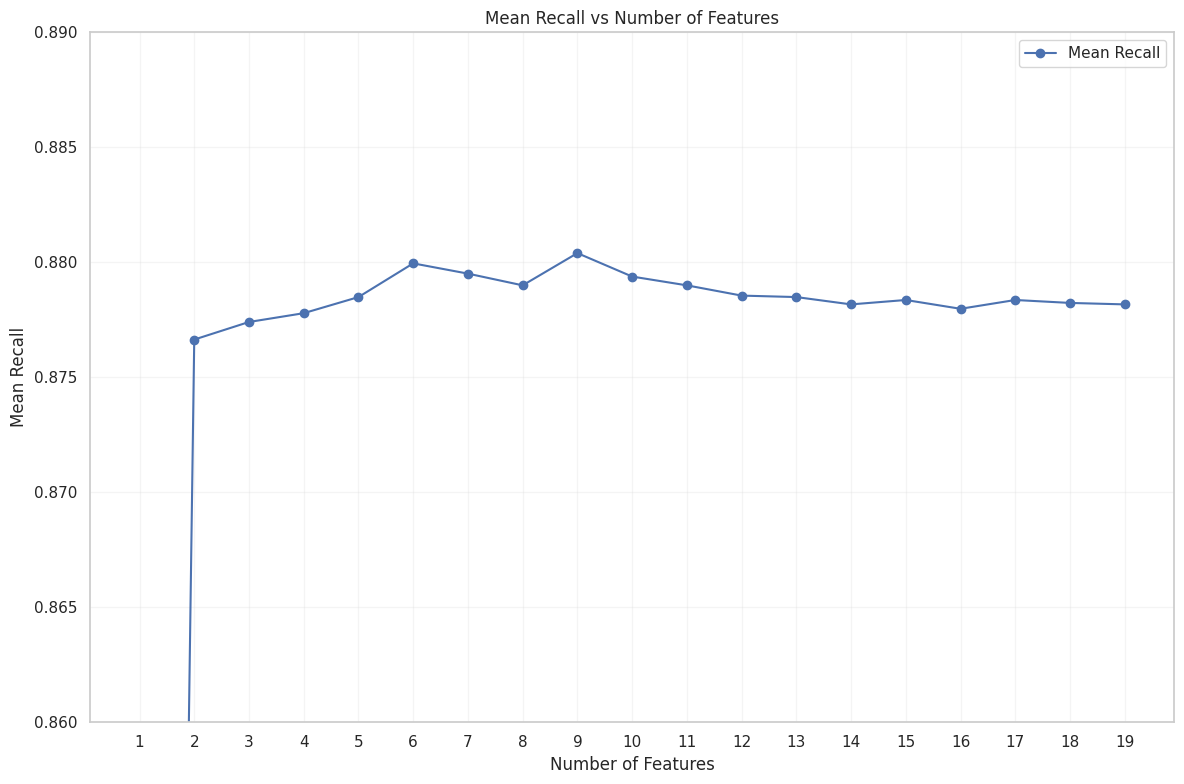

In [45]:

plt.figure(figsize=(12, 8))

plt.plot([r['n_features'] for r in cv_results], 
         [r['mean_recall'] for r in cv_results], 
         marker='o', label='Mean Recall')

plt.xlabel('Number of Features')
plt.ylabel('Mean Recall')
plt.title('Mean Recall vs Number of Features')
plt.legend()
plt.grid(True, alpha=0.2)
plt.xticks(range(1, 20))
plt.ylim(0.86, 0.89)
plt.tight_layout()
plt.show()

In [48]:
# Select top 9 features based on cross-validation results
optimal_n_features = 9

selected_features = feature_importance_df.head(9)['feature'].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.head()


,special_char_ratio,char_count,word_count,avg_word_length,unique_word_ratio,sentence_count,instruction_override_keywords,sql_injection_keywords,system_prompt_leak
14789,0.032787,60,12,4.615385,0.923077,1,0,0,0
25997,0.018519,53,10,4.818182,0.818182,1,0,0,0
3655,0.000000,42,6,6.000000,0.857143,1,0,0,1
1728,0.041096,72,12,5.538462,0.923077,1,0,0,0
11131,0.017857,55,13,3.928571,0.785714,1,0,0,0


In [54]:
X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31387 entries, 14789 to 28287
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   special_char_ratio             31387 non-null  float64
 1   char_count                     31387 non-null  int64  
 2   word_count                     31387 non-null  int64  
 3   avg_word_length                31387 non-null  float64
 4   unique_word_ratio              31387 non-null  float64
 5   sentence_count                 31387 non-null  int64  
 6   instruction_override_keywords  31387 non-null  int64  
 7   sql_injection_keywords         31387 non-null  int64  
 8   system_prompt_leak             31387 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.4 MB


In [51]:
X_test_selected.head()

,special_char_ratio,char_count,word_count,avg_word_length,unique_word_ratio,sentence_count,instruction_override_keywords,sql_injection_keywords,system_prompt_leak
15023,0.000000,56,9,5.600000,0.900000,1,0,0,0
30050,0.000000,42,6,6.000000,0.857143,1,1,1,0
12634,0.028571,349,53,6.462963,0.851852,2,0,0,0
22159,0.021978,90,17,5.000000,0.944444,1,0,1,0
38201,0.040449,444,80,5.481481,0.790123,3,0,0,0


## 4. Feature Scaling

Scale the selected top 9 features

In [55]:

scaler = StandardScaler()

scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)

X_test_scaled = scaler.transform(X_test_selected)

#convert back to DataFrame
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train_selected.columns,
    index=X_train_selected.index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test_selected.columns,
    index=X_test_selected.index
)



In [57]:
X_train_scaled.head()

,special_char_ratio,char_count,word_count,avg_word_length,unique_word_ratio,sentence_count,instruction_override_keywords,sql_injection_keywords,system_prompt_leak
15023,-0.922818,-0.237109,-0.240797,0.135066,0.654448,-0.223523,-0.333325,-0.424424,-0.151916
30050,-0.922818,-0.251781,-0.262100,0.461397,0.211065,-0.223523,2.854386,1.279297,-0.151916
12634,0.040744,0.069960,0.071655,0.839094,0.156327,-0.090225,-0.333325,-0.424424,-0.151916
22159,-0.181617,-0.201476,-0.183987,-0.354430,1.114252,-0.223523,-0.333325,1.279297,-0.151916
38201,0.441326,0.169522,0.263387,0.038376,-0.482290,0.043072,-0.333325,-0.424424,-0.151916


In [58]:
X_test_scaled.head()

,special_char_ratio,char_count,word_count,avg_word_length,unique_word_ratio,sentence_count,instruction_override_keywords,sql_injection_keywords,system_prompt_leak
15023,-0.922818,-0.237109,-0.240797,0.135066,0.654448,-0.223523,-0.333325,-0.424424,-0.151916
30050,-0.922818,-0.251781,-0.262100,0.461397,0.211065,-0.223523,2.854386,1.279297,-0.151916
12634,0.040744,0.069960,0.071655,0.839094,0.156327,-0.090225,-0.333325,-0.424424,-0.151916
22159,-0.181617,-0.201476,-0.183987,-0.354430,1.114252,-0.223523,-0.333325,1.279297,-0.151916
38201,0.441326,0.169522,0.263387,0.038376,-0.482290,0.043072,-0.333325,-0.424424,-0.151916


---

## 5. Model Training and Evaluation

Train and compare 4 classification algorithms using **9 selected features**.

**Models:**
1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. Support Vector Machine (SVM)

In [79]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,     
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    'SVM': SVC(
        kernel='rbf',
        random_state=RANDOM_STATE,
        probability=True
    )
}
print("Models initialized:", len(models))

Models initialized: 4


In [80]:
# training 4 models
results = {}

for name, model in models.items():

    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc
    }

    print("Model: ", model)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1:", f1)
    print("ROC-AUC:", roc_auc)
    print()


print("Training Completed")


Model:  LogisticRegression(max_iter=1000, random_state=42)
Recall: 0.8162120825898547
Precision: 0.8906815020862309
F1: 0.8518222931630753
ROC-AUC: 0.9209361958267495

Model:  GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42)
Recall: 0.8957430537853683
Precision: 0.973137635004154
F1: 0.9328378019644279
ROC-AUC: 0.9617782150952212

Model:  RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)
Recall: 0.8903900076472088
Precision: 0.9842209072978304
F1: 0.9349571734475375
ROC-AUC: 0.9659183094653633

Model:  SVC(probability=True, random_state=42)
Recall: 0.886821310221769
Precision: 0.9772471910112359
F1: 0.9298409728718429
ROC-AUC: 0.95484219934036

Training Completed


In [81]:
comparison_data = []
for model_name in results.keys():
    comparison_data.append({
        'Model': model_name,
        'Recall': results[model_name]['recall'],
        'Precision': results[model_name]['precision'],
        'F1-Score': results[model_name]['f1'],
        'ROC-AUC': results[model_name]['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Recall', ascending=False)
print(comparison_df.to_string(index=False))
print()

best_model_name = comparison_df.iloc[0]['Model']
best_recall = comparison_df.iloc[0]['Recall']
print("Best Model:", best_model_name)
print("Recall:", round(best_recall, 4))


              Model   Recall  Precision  F1-Score  ROC-AUC
  Gradient Boosting 0.895743   0.973138  0.932838 0.961778
      Random Forest 0.890390   0.984221  0.934957 0.965918
                SVM 0.886821   0.977247  0.929841 0.954842
Logistic Regression 0.816212   0.890682  0.851822 0.920936

Best Model: Gradient Boosting
Recall: 0.8957




## 6. Model Performance Visualizations

Detailed visualization of model accuracy and performance metrics.

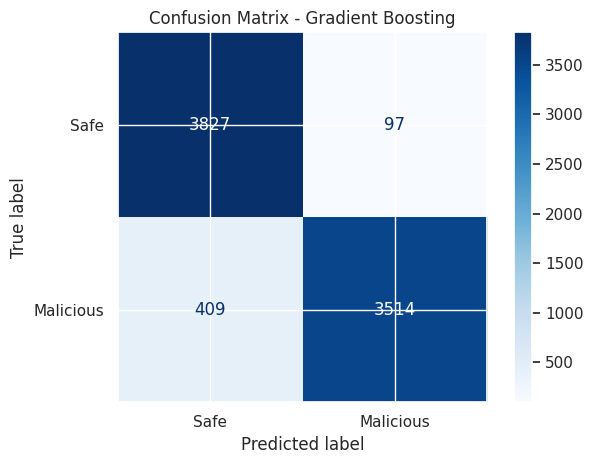

False Negatives (Missed Attacks): 409
False Positives (False Alarms): 97


In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = results[best_model_name]['predictions']

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Safe', 'Malicious'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - ' + best_model_name)
plt.tight_layout()
plt.show()


false_negatives = (y_test == 1) & (y_pred == 0)
false_positives = (y_test == 0) & (y_pred == 1)

print("False Negatives (Missed Attacks):", false_negatives.sum())
print("False Positives (False Alarms):", false_positives.sum())

In [113]:
correct_attacks = (y_test == 1) & (y_test == y_pred)

diffs = []


for feature in X_test_scaled.columns:
    caught = X_test_scaled.loc[correct_attacks, feature].mean()
    missed = X_test_scaled.loc[false_negatives, feature].mean()
    diff = missed - caught

    diffs.append({
        'feature': feature,
        'caught': caught,
        'missed': missed,
        'diff': diff
    })

diffs.sort(key=lambda x: x['diff'])

for item in diffs:
    feat_name = item['feature']
    caught_val = item['caught']
    missed_val = item['missed']
    diff_val = item['diff']
    print(f"{feat_name:<33} Caught={caught_val:>7.3f}  Missed={missed_val:>7.3f}  Diff={diff_val:>+7.3f}")
      

avg_word_length                   Caught=  0.466  Missed= -0.348  Diff= -0.814
instruction_override_keywords     Caught=  0.412  Missed= -0.310  Diff= -0.722
sql_injection_keywords            Caught=  0.348  Missed= -0.287  Diff= -0.635
char_count                        Caught=  0.291  Missed= -0.218  Diff= -0.509
word_count                        Caught=  0.283  Missed= -0.208  Diff= -0.491
sentence_count                    Caught=  0.288  Missed= -0.190  Diff= -0.478
system_prompt_leak                Caught=  0.243  Missed= -0.152  Diff= -0.394
special_char_ratio                Caught= -0.097  Missed=  0.116  Diff= +0.214
unique_word_ratio                 Caught= -0.498  Missed=  0.274  Diff= +0.772


In [ ]:
print("avg_word_length is the biggest gap betwen caught and missed attacks. This is my model's biggest blind spot. ")